In [46]:
#!/home/akhanal1/Spring2018/pl-env/bin/python3.5
import os
os.chdir("c:\\Projects\\ature")
import sys
import path_config as pth
import numpy as np
import itertools as itr
from random import shuffle
from commons.segmentation import AtureTest
from PIL import Image as IMG
from commons.IMAGE import Image, MatImage

sep = os.sep
data_file_path = pth.DATA_PATH + sep + 'DRIVE' + sep + 'test' + sep + 'images'
av_data = pth.DATA_PATH + sep + 'av_wide_data_set'

mask_path = pth.DATA_PATH + sep + 'DRIVE' + sep + 'test' + sep + 'mask'
ground_truth_path = pth.DATA_PATH + sep + 'DRIVE' + sep + 'test' + sep + '1st_manual'

# for ubuntu
sys.path.append(pth.CONTEXT_PATH)
os.chdir(pth.CONTEXT_PATH)


def get_mask_file(file_name): return file_name.split('_')[0] + '_test_mask.gif'


def get_ground_truth_file(file_name): return file_name.split('_')[0] + '_manual1.gif'


SK_THRESHOLD_PARAMS = np.arange(40, 61, 20)
ALPHA_PARAMS = np.arange(5, 7, 0.5)
GABOR_CONTRIBUTION_PARAMS = np.arange(0.6, 1.1, 0.2)
SEGMENTATION_THRESHOLD_PARAMS = np.arange(9, 15, 0.5)

PARAMS_ITR = itr.product(SK_THRESHOLD_PARAMS, ALPHA_PARAMS, GABOR_CONTRIBUTION_PARAMS, SEGMENTATION_THRESHOLD_PARAMS)

PARAMS_COMBINATION = list(PARAMS_ITR)
shuffle(PARAMS_COMBINATION)

keys = ('sk_threshold', 'alpha', 'gabor_contrib', 'seg_threshold')

all_params = list(dict(zip(keys, param)) for param in PARAMS_COMBINATION)

params = {'sk_threshold': 60,
          'alpha': 5.5,
          'gabor_contrib': 1,
          'seg_threshold': 9.0}

In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
### Run for image files with in-time mask erosion
img_obj = Image(data_dir=data_file_path, file_name='16_test.tif')
img_obj.load_mask(mask_dir=mask_path, fget_mask=get_mask_file, erode=True)
img_obj.load_ground_truth(gt_dir=ground_truth_path, fget_ground_truth=get_ground_truth_file)

tester = AtureTest(data_dir=data_file_path, out_dir=os.path.join(pth.OUT_PATH, 'out_new'))
acc = tester.run_for_one_image(image_obj=img_obj, params=params, save_images=False, epochs=1, alpha_decay=0.4)
# tester.run_for_all_images(params_combination=all_params)


### Run for mask fixed by Dr. Estrada
# mask_path = pth.DATA_PATH + sep + 'DRIVE' + sep + 'test' + sep + 'mask_fixed'
# img_obj = Image(data_dir=data_file_path, file_name='16_test.tif')
# img_obj.load_mask(mask_dir=mask_path, fget_mask=get_mask_file, erode=False)
# img_obj.load_ground_truth(gt_dir=ground_truth_path, fget_ground_truth=get_ground_truth_file)
# tester = AtureTest(data_dir=data_file_path, out_dir=os.path.join(pth.OUT_PATH, 'out_new'))
# acc = tester.run_for_one_image(image_obj=img_obj, params=params, save_images=False, epochs=1, alpha_decay=0.4)

## Run for mat files in av_wide_data_set dir
# img_obj = MatImage(data_dir=data_file_path, file_name='******.mat')
# img_obj.load_mask(mask_dir=mask_path, fget_mask=get_mask_file, erode=True)
# img_obj.load_ground_truth(gt_dir=ground_truth_path, fget_ground_truth=get_ground_truth_file)

# tester = AtureTest(data_dir=data_file_path, out_dir=os.path.join(pth.OUT_PATH, 'out_new'))
# acc = tester.run_for_one_image(image_obj=img_obj, params=params, save_images=False, epochs=1, alpha_decay=0.4)

### File loaded: 16_test.tif
Mask loaded: 16_test_mask.gif
Ground truth loaded: 16_manual1.gif
"apply_bilateral(__)" ... took 0.109 seconds
"apply_gabor(__)" ... took 1.05 seconds
"generate_lattice_graph(__)" ... took 2.14 seconds
Running epoch: 0
"create_skeleton(__)" ... took 0.016 seconds
"run_segmentation(__)" ... took 54.068 seconds
"_calculate_scores(__)" ... took 3.157 seconds
"_generate_rgb(__)" ... took 2.045 seconds
"_generate_rgb(__)" ... took 2.047 seconds
Number of params combination tried: 1


In [ ]:
# import pandas as pd
# df =pd.read_csv('out/segmentation_result.csv')

In [ ]:
# df = df.query('FILE_NAME=="16_test.tif"')

In [ ]:
# grouped = df.groupby(['SK_THRESHOLD','ALPHA','GABOR_CONTRIB','SEG_THRESHOLD']).mean().reset_index()
# grouped_sorted = grouped.sort_values(by='FSCORE', ascending=False)

In [ ]:
# grouped_sorted.head()

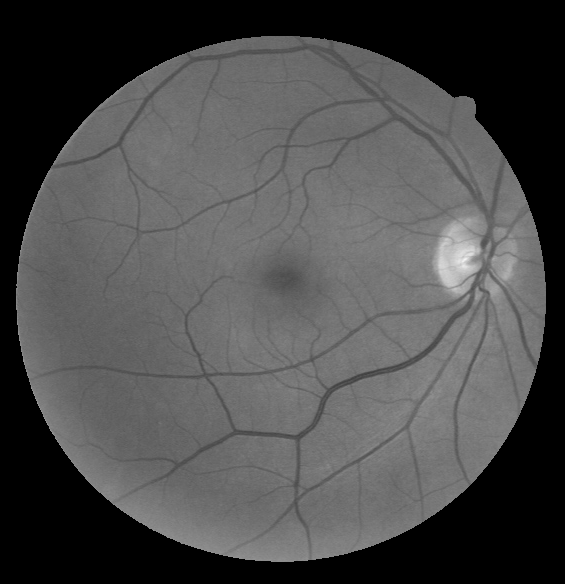

In [49]:
IMG.fromarray(acc.img_obj.working_arr)

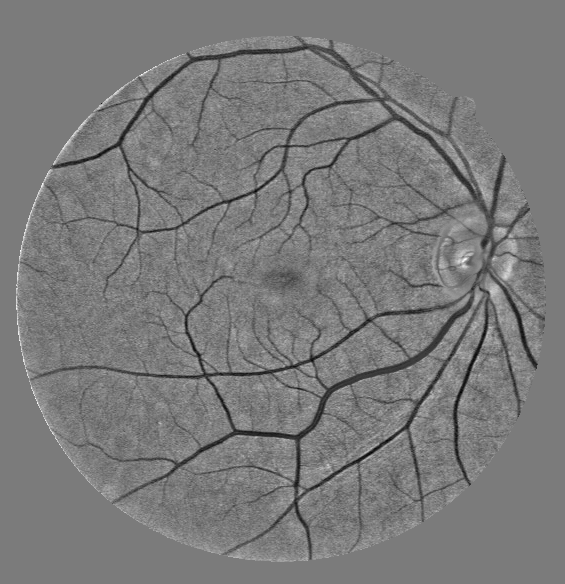

In [50]:
IMG.fromarray(acc.img_obj.diff_bilateral)

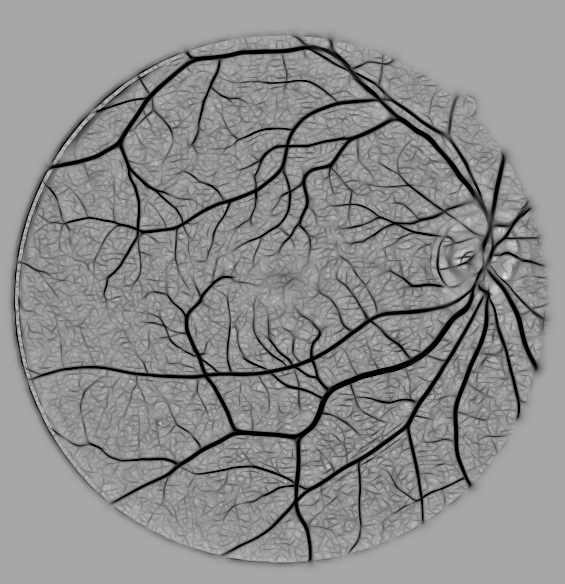

In [51]:
IMG.fromarray(acc.img_obj.img_gabor)

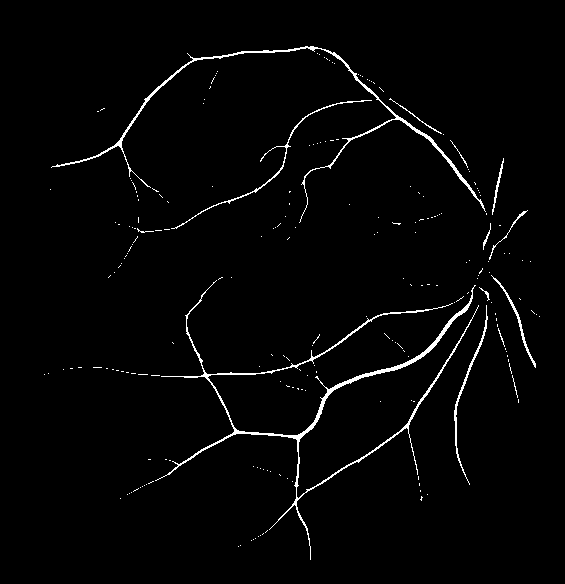

In [52]:
IMG.fromarray(255-acc.res['skeleton0'])

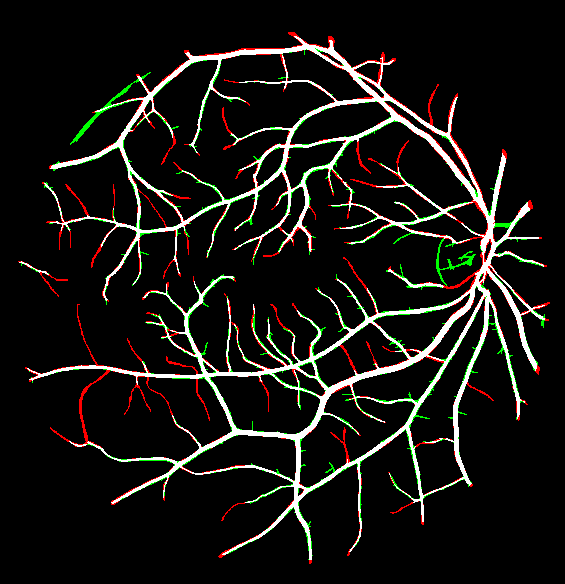

In [53]:
IMG.fromarray(acc.res['segmented0'])

In [54]:
print(acc.res['scores0'])

{'Precision': 0.8256289811750471, 'Recall': 0.7787922526937666, 'Accuracy': 0.9651775972845194, 'F1': 0.8015269812754784}


In [55]:
print(acc.res['params0'])

{'sk_threshold': 60, 'alpha': 5.5, 'gabor_contrib': 1, 'seg_threshold': 9.0}


In [56]:
# IMG.fromarray(255-acc.res['skeleton1'])

In [57]:
# IMG.fromarray(acc.res['segmented1'])

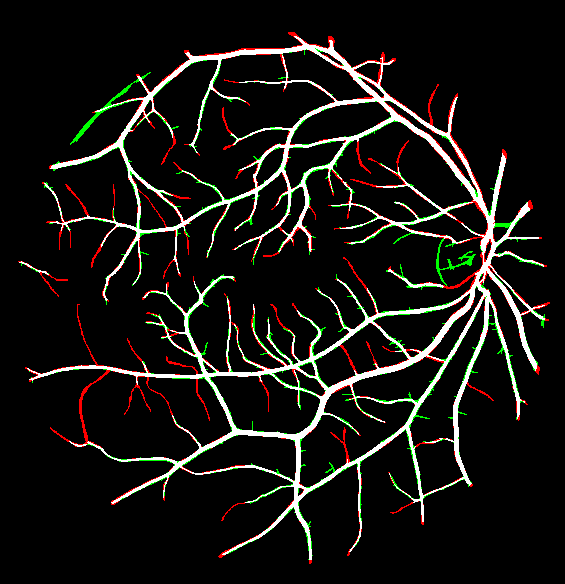

In [58]:
IMG.fromarray(acc.arr_rgb)

In [59]:
import preprocess.utils.img_utils as ig

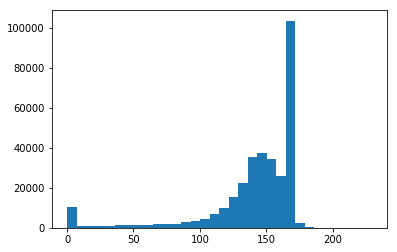

In [61]:
ig.histogram(acc.img_obj.img_gabor)